# Model selection and validation

In this notebook we determine which of the following sklearn machine learning models is best for predicting numerical digits from $0$ to $9$ based on a range of given hyperparameters using The Digit Dataset [Scikit-Learn.org](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) |  [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) | [Model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)\.


In [1]:
import sklearn
from sklearn import datasets

digits = datasets.load_digits()

<table style="border: 1px solid black;">
  <tr>
    <th style="border: 1px solid black;">Model</th>
    <th style="border: 1px solid black;">Hyperparameter</th>
    <th style="border: 1px solid black;">Testing range</th>
    <th style="border: 1px solid black;">Notes</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Support Vector Machine</td>
    <td style="border: 1px solid black;"><b>Gamma</b> - size of the kernel <br /><b>C</b> - slack variable</td>
    <td style="border: 1px solid black;">$10^{-x}$ for $x = -5$ to $5$</td>
    <td style="border: 1px solid black;">use the ‘rbf’: radial basis function kernel</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">K-nearest neighbors</td>
    <td style="border: 1px solid black;"><b>k</b> - number of neighbors</td>
    <td style="border: 1px solid black;">$1,3,5,7,9$</td>
    <td style="border: 1px solid black;">use the sklearn function</td>
  </tr>
    <tr>
    <td style="border: 1px solid black;">Decision Trees</td>
    <td style="border: 1px solid black;"><b>min_samples_split</b></td>
    <td style="border: 1px solid black;">$1,3,5,7,9$</td>
    <td style="border: 1px solid black;">use the defaults for the other hyperparameters.</td>
  </tr>
    <tr>
    <td style="border: 1px solid black;">Logistic Regression</td>
    <td style="border: 1px solid black;"><b>C</b> - inverse of the the regularization strength <br /> (smaller = more regularization)</td>
    <td style="border: 1px solid black;">$10^{-x}$ for $x = -5$ to $5$</td>
    <td style="border: 1px solid black;">with the L1 penalty (Lasso)</td>
  </tr>
</table>

### 1. Separate data into training and testing. Use cross-validation to select the right parameters
- We use **train_test_split** to create a separate training and test set.
- `X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=True, test_size=0.20)`
- Setting up KFold cross-validation, we  use `n_splits=10` with `shuffle=True`.


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold

x, y = digits.data, digits.target
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20)

skf = StratifiedKFold(n_splits=10, shuffle=True)

The sklearn module is throwing **`FutureWarning`**, **`ConvergenceWarning`**, and **`DeprecationWarning`** because of updates and changes to the  functions we are importing. For learning purposes, let's disable warnings.

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### 2. Train the models and report the accuracy.

In [4]:
import numpy as np
from sklearn import svm, tree, linear_model, model_selection
from sklearn.neighbors import KNeighborsClassifier

default_models = [svm.SVC(),
                  KNeighborsClassifier(),
                  tree.DecisionTreeClassifier(),
                  linear_model.LogisticRegression()]

default_accuracy = []
for model in enumerate(default_models):
    default_accuracy.append(round(np.mean(model_selection.cross_val_score(model[1],x_train,y_train,cv=skf))*100,1))
    print("{} = {} %".format(str(model[1]).split('(')[0],default_accuracy[len(default_accuracy)-1]))

SVC = 54.4 %
KNeighborsClassifier = 98.7 %
DecisionTreeClassifier = 84.9 %
LogisticRegression = 95.8 %


### Cross-validate each model variant and select the best hyperparameters. 

#### $10^{-x}$ for $x = -5$ to $5$

In [5]:
param_range = [10.0**-x for x in range(-5,5)]
param_range

[100000.0, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]

#### Odd numbers from 1 to 9

In [6]:
param_odds = list(range(1, 10, 2))
param_odds

[1, 3, 5, 7, 9]

 - For each of the four models, we will find the hyperparameters giving the highest accuracy by performing an exhaustive grid search. 
  - Report the hyperparameter values and accuracy.
  - We use `sklearn.model_selection.GridSearchCV`
  - Models with two or more hyperparameters need to search through every possible combination.

In [7]:
from sklearn.model_selection import GridSearchCV

grid = [GridSearchCV(svm.SVC(kernel="rbf"), {'C':param_range,'gamma':param_range}).fit(x_train, y_train),
        GridSearchCV(KNeighborsClassifier(), {'n_neighbors':param_odds}).fit(x_train,y_train),
        GridSearchCV(tree.DecisionTreeClassifier(), {'min_samples_split':[1.0,3,5,7,9]}).fit(x_train, y_train),
        GridSearchCV(linear_model.LogisticRegression(penalty='l1'), {'C':param_range}).fit(x_train, y_train)]

for model in enumerate(grid):
    print("{} = {} % with {}".format(str(model[1].best_estimator_).split('(')[0],round(model[1].best_score_,2)*100,model[1].best_params_))

SVC = 99.0 % with {'C': 1.0, 'gamma': 0.001}
KNeighborsClassifier = 98.0 % with {'n_neighbors': 1}
DecisionTreeClassifier = 83.0 % with {'min_samples_split': 3}
LogisticRegression = 96.0 % with {'C': 0.1}


### Apply the highest accuracy trained models to the test set. 
- Report the accuracy of each model against the test set.

In [8]:
models = [svm.SVC(kernel='rbf',C=grid[0].best_params_.get("C"),gamma=grid[0].best_params_.get("gamma")),
          KNeighborsClassifier(n_neighbors=grid[1].best_params_.get("n_neighbors")),
          tree.DecisionTreeClassifier(min_samples_split=grid[2].best_params_.get("min_samples_split")),
          linear_model.LogisticRegression(penalty='l1',C=grid[3].best_params_.get("C"))]

test_accuracy = []
for model in enumerate(models):
    test_accuracy.append(round(np.mean(model_selection.cross_val_score(model[1],x_test,y_test,cv=skf))*100,1))
    print("{} = {} %".format(str(model[1]).split('(')[0],test_accuracy[len(test_accuracy)-1]))

SVC = 97.1 %
KNeighborsClassifier = 96.7 %
DecisionTreeClassifier = 80.1 %
LogisticRegression = 93.5 %


### Table of outputs.

In [9]:
import pandas as pd
from IPython.display import display, HTML

df = pd.DataFrame({"Model": ["SVM", "k-NN", "Decision Trees", "Logistic Regression"],
                    "Default validation accuracy": ["{} %".format(model[1]) for model in enumerate(default_accuracy)],
                    "Tuned validation accuracy": ["{} %".format(round(model[1].best_score_,2)*100,model[1].best_params_) for model in enumerate(grid)],
                    "Selected hyperparameters": ["{}".format(str(model[1].best_params_).strip("{}").replace("'", "").replace(":", " =").replace(",", " | ")) for model in enumerate(grid)],
                    "Final test set accuracy": ["{} %".format(model[1]) for model in enumerate(test_accuracy)]})

display(HTML(df.to_html(index=False)))

Model,Default validation accuracy,Tuned validation accuracy,Selected hyperparameters,Final test set accuracy
SVM,54.4 %,99.0 %,C = 1.0 | gamma = 0.001,97.1 %
k-NN,98.7 %,98.0 %,n_neighbors = 1,96.7 %
Decision Trees,84.9 %,83.0 %,min_samples_split = 3,80.1 %
Logistic Regression,95.8 %,96.0 %,C = 0.1,93.5 %


### Bar graph of accuracy

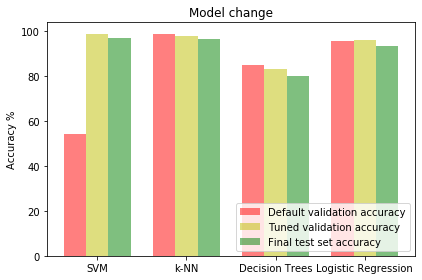

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
index, bar_width, opacity = np.arange(4), 0.25, 0.5

plt.bar(index, default_accuracy, bar_width,alpha=opacity,color='r',label='Default validation accuracy')
plt.bar(index + bar_width, [round(model[1].best_score_,2)*100 for model in enumerate(grid)], bar_width,alpha=opacity,color='y',label='Tuned validation accuracy')
plt.bar(index + bar_width + bar_width, test_accuracy, bar_width,alpha=opacity,color='g',label='Final test set accuracy')
plt.ylabel('Accuracy %'), plt.title('Model change'), plt.xticks(index + bar_width, ('SVM', 'k-NN', 'Decision Trees', 'Logistic Regression')), plt.legend(loc='lower right'), plt.tight_layout()

plt.show()

### SVM parameters

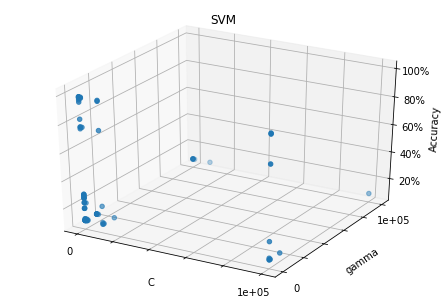

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick

x,y,z = [],[],[]
for mean, params in zip(grid[0].cv_results_['mean_test_score'], grid[0].cv_results_['params']):
    x.append(params.get("C"))
    y.append(params.get("gamma"))
    z.append(float(mean)*100)

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('C'), ax.set_ylabel('gamma'), ax.set_zlabel('Accuracy'), ax.scatter(x, y, z), plt.title('SVM')
ax.get_xaxis().set_major_formatter(plt.LogFormatter(10)), ax.get_yaxis().set_major_formatter(plt.LogFormatter(10))

zticks = mtick.FormatStrFormatter('%.0f%%')
ax.zaxis.set_major_formatter(zticks)

plt.show()

### k-NN parameters

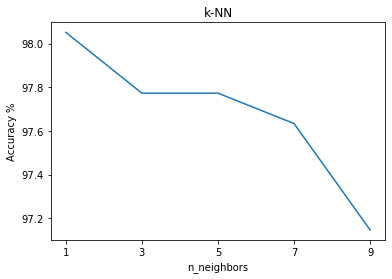

In [12]:
x,y = [],[]
for mean, params in zip(grid[1].cv_results_['mean_test_score'], grid[1].cv_results_['params']):
    x.append(params.get("n_neighbors"))
    y.append(float(mean)*100)

plt.plot(x, y) 
plt.xlabel('n_neighbors'), plt.ylabel('Accuracy %'), plt.title('k-NN'), plt.xticks(param_odds)

plt.show() 

### Decision Tree parameters 

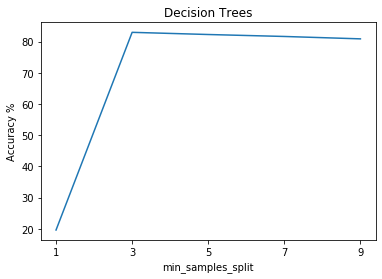

In [13]:
x,y = [],[]
for mean, params in zip(grid[2].cv_results_['mean_test_score'], grid[2].cv_results_['params']):
    x.append(params.get("min_samples_split"))
    y.append(float(mean)*100)

plt.plot(x, y) 
plt.xlabel('min_samples_split'), plt.ylabel('Accuracy %'), plt.title('Decision Trees'), plt.xticks(param_odds)

plt.show() 

### Logistic Regression parameters

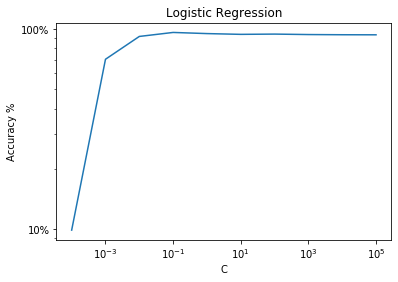

In [14]:
from matplotlib.ticker import PercentFormatter

x,y = [],[]
for mean, params in zip(grid[3].cv_results_['mean_test_score'], grid[3].cv_results_['params']):
    x.append(params.get("C"))
    y.append(float(mean)*100)

plt.loglog(x, y) 
plt.xlabel('C'), plt.ylabel('Accuracy %'), plt.title('Logistic Regression') 
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))

plt.show() 